In [2]:
from numpy import array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input

# Cargar los datos
df = pd.read_csv("datos.csv", parse_dates=True)

# Crear los dataFrames con ambas columnas y ventanas temporales
columnaDatos = df['value']
columnaFechas = df['timestamp']
nDatosVentana = 5
ventana = np.lib.stride_tricks.sliding_window_view(columnaDatos, window_shape=nDatosVentana)

# Convertimos en array numpy
X = array(ventana)  

# Redimensionar los datos para el autoencoder
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

X

array([[[69.88083514],
        [71.22022706],
        [70.87780496],
        [68.95939994],
        [69.28355102]],

       [[71.22022706],
        [70.87780496],
        [68.95939994],
        [69.28355102],
        [70.06096581]],

       [[70.87780496],
        [68.95939994],
        [69.28355102],
        [70.06096581],
        [69.27976479]],

       ...,

       [[68.03307954],
        [70.45571697],
        [72.37020644],
        [72.17295622],
        [72.04656545]],

       [[70.45571697],
        [72.37020644],
        [72.17295622],
        [72.04656545],
        [71.82522648]],

       [[72.37020644],
        [72.17295622],
        [72.04656545],
        [71.82522648],
        [72.58408858]]])

In [3]:
# Crear el autoencoder LSTM
model = Sequential()
model.add(Input(shape=(nDatosVentana, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(RepeatVector(nDatosVentana))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
model.summary()

# Entrenar el autoencoder
model.fit(X, X, epochs=100, batch_size=32)

# Hacer predicciones sobre el conjunto de datos
y_pred = model.predict(X)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 5, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 1)           │           101 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 609.8399
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6249
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3632
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2705
Epoch 5/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3014
Epoch 6/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2903
Epoch 7/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2909
Epoch 8/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3656
Epoch 9/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2415
Epoch 10/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2632
Epoch 11/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2765
Epoch 12/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2790
Epoch 13/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3299
Epoch 14/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3283
Epoch 15/100
227/227 ━━━━━━━━━━━━━━━━━━━━

In [4]:
# Calcular el error absoluto en cada predicción para identificar anomalías
errors = np.mean(abs(X - y_pred), axis=1)  # Error promedio por ventana

# Calcular el umbral basado en el error promedio y desviación estándar
mae = np.mean(errors)
std_error = np.std(errors)
threshold = 2 * mae + std_error

print(f"Error Absoluto Medio (MAE): {mae}")
print(f"Desviacion estandar: {std_error}")
print(f"Umbral: {threshold}")


Error Absoluto Medio (MAE): 0.07230735747643396
Desviacion estandar: 0.03522526819358337
Umbral: 0.1798399831464513


In [5]:
# Convertir fechas a array de numpy
columnaFechas = array(columnaFechas[nDatosVentana - 1:])
anomalies = []

# Detectar e imprimir anomalías
for index in range(len(y_pred)):
    error = errors[index]
    if error > threshold:
        expected = y_pred[index, -1, 0]  # Último valor de la predicción para la ventana
        received = X[index, -1, 0]       # Último valor de los datos originales en la ventana
        difference = abs(received - expected)
        print(f"Fecha: {columnaFechas[index]}, Esperado: {expected}, Recibido: {received}, Diferencia: {difference}")
        anomalies.append(True)
    else:
        anomalies.append(False)

anomalies = np.array(anomalies)

# Resumen de las anomalías
print("El número de anomalías es " + str(np.sum(anomalies)) + " sobre " + str(df.shape[0]))

Fecha: 2013-08-06 20:00:00, Esperado: 65.40040588378906, Recibido: 65.26017655, Diferencia: 0.14022933378906544
Fecha: 2013-08-06 21:00:00, Esperado: 74.52938079833984, Recibido: 74.76223447, Diferencia: 0.23285367166015192
Fecha: 2013-08-06 22:00:00, Esperado: 72.9209976196289, Recibido: 73.49525372, Diferencia: 0.5742561003710875
Fecha: 2013-08-06 23:00:00, Esperado: 72.57520294189453, Recibido: 73.36538505, Diferencia: 0.7901821081054692
Fecha: 2013-08-07 00:00:00, Esperado: 72.5096206665039, Recibido: 72.5976732, Diferencia: 0.08805253349609643
Fecha: 2013-08-12 12:00:00, Esperado: 67.69147491455078, Recibido: 67.94979306, Diferencia: 0.2583181454492234
Fecha: 2013-10-17 00:00:00, Esperado: 72.43388366699219, Recibido: 72.76152535, Diferencia: 0.32764168300781193
Fecha: 2013-10-17 01:00:00, Esperado: 72.13981628417969, Recibido: 72.84667905, Diferencia: 0.7068627658203184
Fecha: 2013-10-17 02:00:00, Esperado: 73.66056060791016, Recibido: 74.06782481, Diferencia: 0.4072642020898485


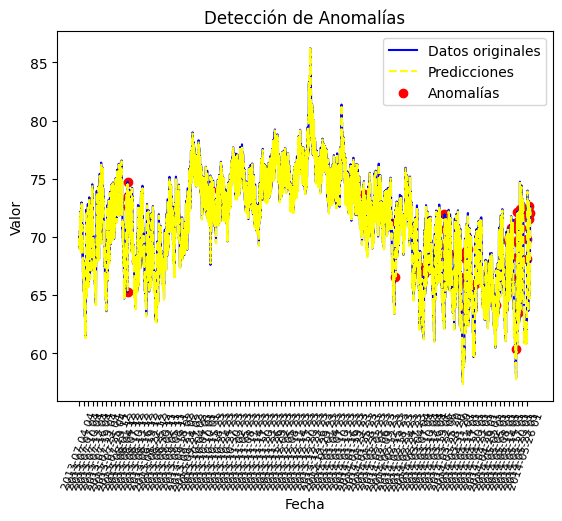

In [6]:
# Visualización de resultados
plt.plot(columnaFechas, columnaDatos[nDatosVentana - 1:], color='blue', label='Datos originales')
plt.plot(columnaFechas, y_pred[:, -1, 0], color='yellow', linestyle='--', label='Predicciones')  # Predicción en amarillo
plt.scatter(columnaFechas[anomalies], columnaDatos[nDatosVentana - 1:][anomalies], color='red', label='Anomalías')
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.title("Detección de Anomalías")

# Configurar ticks en el eje X cada 3 días para claridad
columnaFechas = pd.to_datetime(columnaFechas)
tick_positions = np.arange(0, len(columnaFechas), 72)
tick_labels = [date.strftime("%Y-%m-%d %H") for date in columnaFechas[tick_positions]]

plt.xticks(tick_positions, tick_labels, rotation=70, fontsize=8)
plt.legend()
plt.show()